# Week 6 Problem 3

If you are not using the `Assignments` tab on the course JupyterHub server to read this notebook, read [Activating the assignments tab](https://github.com/lcdm-uiuc/info490-sp17/blob/master/help/act_assign_tab.md).

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do **not** write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select _Kernel_, and restart the kernel and run all cells (_Restart & Run all_).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select _File_  → _Save and CheckPoint_)

5. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.
-----
# Problem 6.3. Practical Concepts

In this problem, we explore a number of practical concepts that can be very important in real-world machine learning applications. These concepts include

- Feature Scaling
- Feature Selection
- Pipelining
- Cross Validation
- Grid Search
- Validation/Learning Curves

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from sklearn import preprocessing
from sklearn import svm
from sklearn import cross_validation as cv
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import validation_curve

from nose.tools import assert_equal, assert_is_instance, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal, assert_almost_equal

The dataset we're going to handle is a collection of shape and texture features extracted from digital images of leaf specimens orginating from a total of about 40 different plant species. The csv data file has 16 columns and we could drop out the second column, `Specimen Number`, because it is not relevant to classification. The integers in `Class (Species)` represent leaves of different classes/species as in the following image:
![](./images/leaf.png)
We'll use `Class (Species)` as classes, and the rest 15 columns as features.

In [2]:
# data from https://archive.ics.uci.edu/ml/datasets/Leaf
file = '/home/data_scientist/data/misc/leaf.csv'
leaves = pd.read_csv(file, names=['Class (Species)', 'Specimen Number', 'Eccentricity', 'Aspect Ratio',
                                  'Elongation', 'Solidity', 'Stochastic Convexity', 'Isoperimetric Factor', 
                                  'Maximal Indentation Depth', 'Lobedness', 'Average Intensity', 
                                  'Average Contrast', 'Smoothness', 'Third Moment', 'Uniformity', 'Entropy'])

leaves = leaves.drop('Specimen Number', axis=1)

In [3]:
print(leaves.head())

   Class (Species)  Eccentricity  Aspect Ratio  Elongation  Solidity  \
0                1       0.72694        1.4742     0.32396   0.98535   
1                1       0.74173        1.5257     0.36116   0.98152   
2                1       0.76722        1.5725     0.38998   0.97755   
3                1       0.73797        1.4597     0.35376   0.97566   
4                1       0.82301        1.7707     0.44462   0.97698   

   Stochastic Convexity  Isoperimetric Factor  Maximal Indentation Depth  \
0               1.00000               0.83592                   0.004657   
1               0.99825               0.79867                   0.005242   
2               1.00000               0.80812                   0.007457   
3               1.00000               0.81697                   0.006877   
4               1.00000               0.75493                   0.007428   

   Lobedness  Average Intensity  Average Contrast  Smoothness  Third Moment  \
0   0.003947           0.047790

In [4]:
f = leaves.drop('Class (Species)', axis=1) # features
c = leaves['Class (Species)'] # classes

## Feature Scaling

We have explored feature scaling in [Problem 5.1](../Week5/Assignments/w5p1.ipynb), so I'll do this for you.

In [5]:
f_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(f), columns=f.columns)

## Feature Selection

Now we'll try to do feature selection using both [Recursive Feature Elimination (RFE)](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) and [Random Forest Classifier (RFC)](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). 

In the following cell, use [Recursive Feature Elimination](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) to determine the most important features.

In [6]:
def select_features_rfe(X, y, random_state, kernel='linear', C=1.0, num_attributes=3):
    '''
    Uses Support Vector Classifier as the estimator to rank features
    with Recursive Feature Elimination.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in SVC().
    kernel: A string. Used in SVC(). Default: "linear".
    C: A float. Used in SVC(). Default: 1.0.
    num_attributes: An int. The number of features to select in RFE. Default: 3.
    
    Returns
    -------
    A 3-tuple of (RFE, np.ndarray, np.ndarray)
    rfe: An RFE instance.
    columns: Selected column names. A numpy array of strings.
    ranking: The feature ranking. Selected features are assigned rank 1. A numpy array of integers.
    '''
    
    # YOUR CODE HERE
    svc = svm.SVC(kernel = kernel, C = C, random_state = random_state)
    rfe = RFE(svc, num_attributes)
    rfe = rfe.fit(X, y)
    # the mask of selected features
    columns = X.columns[rfe.support_]
    ranking = rfe.ranking_
    
    return rfe, columns, ranking

In [7]:
t_rfe, t_columns, t_ranking = select_features_rfe(f_scaled, c, check_random_state(0))

In [8]:
assert_is_instance(t_rfe, RFE)
assert_is_instance(t_ranking, np.ndarray)

assert_is_instance(t_rfe.estimator, svm.SVC)
assert_equal(t_rfe.estimator.kernel, 'linear')
assert_equal(t_rfe.estimator.C, 1)
assert_equal(t_rfe.n_features_, 3)

assert_array_equal(t_columns, ['Eccentricity', 'Isoperimetric Factor', 'Average Contrast'])
assert_array_equal(t_ranking, [1, 8, 2, 5, 10, 1, 3, 12, 11, 1, 9, 7, 6, 4])

In the following cell, use [Random Forest Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to determine the most important features.

In [9]:
def select_features_rfc(X, y, random_state, n_estimators=10, n_selected_columns=3):
    '''
    Uses Random Forest Classifier as the estimator to rank features.
    Sorts feature columns based on importances, and returns
    specified number of column names with highest importances.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    n_estimator: A float. Used in RandomForestClassifier(). Default: 10.
    n_selected_columns: An int. The number of features/columns to select. Default: 3.
    
    Returns
    -------
    A 3-tuple of (RFC, np.ndarray, np.ndarray)
    rfc: An RFC instance.
    columns: Selected column names. A numpy array of strings.
    importance: The feature importances. A numpy array of floats.
    '''
    
    # YOUR CODE HERE
    rfc = RandomForestClassifier(n_estimators = n_estimators, random_state = random_state)
    rfc.fit(X, y)
    
    importance = rfc.feature_importances_
    # get the indices for the largest 3 values
    index = importance.argsort()[-n_selected_columns:][::-1]
    
    columns = np.array(X.columns[index])
    
    return rfc, columns, importance

In [10]:
u_rfc, u_columns, u_importance = select_features_rfc(f_scaled, c, check_random_state(0))

In [11]:
assert_is_instance(u_rfc, RandomForestClassifier)
assert_is_instance(u_importance, np.ndarray)

assert_array_equal(u_columns, ['Eccentricity', 'Solidity', 'Entropy'])
assert_array_almost_equal(u_importance, 
                          [ 0.1004033 ,  0.0796833 ,  0.08358279,  0.09997119,  0.06706054,
                            0.08678733,  0.05865014,  0.07139296,  0.04943292,  0.04209375,
                            0.06102167,  0.04721591,  0.06452248,  0.08818172])

## Pipeline Anova RFC
Construct a pipeline that selects the `k` best features from a data set using an ANOVA filter (see [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)), and then employs a Random Forest Classification. Use [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) for the score function. Name the pipe elements "anova" and "rfc".

In [12]:
def anova_rfc_pipeline(X, y, random_state, k=3, n_estimators=10, max_depth=4):
    '''
    Selects top k features with a pipeline that uses ANOVA F-value
    and a Random Forest Classifier.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    k: An int. The number of features to select. Default: 3.
    n_estimators: A float. Used by RandomForestClassifier(). Default: 10.
    max_depth: A float. Used by RandomForestClassifier(). Default: 4.
    
    Returns
    -------
    A 2-tuple of (Pipeline, np.ndarray)
    model: An ANOVA RFC pipeline.
    predictions: Classifications predicted by the pipeline.
    '''
    
    # YOUR CODE HERE
    
    anova = SelectKBest(f_classif, k = k)
    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                 random_state = random_state,
                                 max_depth = max_depth)

    # Create a pipeline, with names for pipe elements
    model = Pipeline([('anova', anova), ('rfc', rfc)])

    # You can set the parameters using the names
    model.set_params(anova__k = k).fit(X, y)
    prediction = model.predict(X)
    
    return model, prediction

In [13]:
t_model, t_pred = anova_rfc_pipeline(f_scaled, c, random_state=check_random_state(0), n_estimators=30, max_depth=6)

In [14]:
assert_is_instance(t_model, Pipeline)
assert_equal(t_model.steps[0][0], 'anova')
assert_equal(t_model.steps[1][0], 'rfc')
assert_equal(t_model.get_params()['anova__k'], 3)
assert_equal(t_model.get_params()['rfc__n_estimators'], 30)
assert_equal(t_model.get_params()['rfc__max_depth'], 6)

assert_is_instance(t_pred, np.ndarray)
assert_equal(len(t_pred), 340)
assert_array_equal(t_pred[:15], [13,  1,  1,  1,  1, 13,  1,  1,  1, 14, 13,  1,  2,  2,  2])
assert_array_equal(t_pred[-15:], [35, 35, 35, 35, 12, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36])

## Grid Search

Use a [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) object to compute the best value for the `max_depth` parameter when running the RFC algorithm. You may want to refer to [Problem 4.3](../Week4/assignments/w4p3.ipynb).

In [15]:
def find_best_max_depth(X, y, split_random_state, rfc_random_state, max_depth_values, test_size=0.2, n_estimators=10):
    '''
    Do a grid search to find the optimized max_depth parameter.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Features.
    y: A pandas.DataFrame. Classes.
    split_random_state: A RandomState instance. Used in train_test_split().
    rfc_random_state: A RandomState instance. Used in RandomForestClassifier().
    max_depth_values: A np.array. A list of parameter settings to try as max_depth.
    test_size: A float. Used in train_test_split(). Default: 0.2.
    n_estimators: A float. Used by RandomForestEstimator(). Default: 10.

    Returns
    -------
    A 3-tuple of (GridSearchCV, float, float)
    model: A GridSearchCV instance.
    best_max_depth: The value of max_depth that gave the highest score.
    best_cv_score: Score of best_max_depth on the hold out data.
    '''
    
    # YOUR CODE HERE
    y = np.ravel(y) 
    X_train, X_test, y_train, y_test = cv.train_test_split(X, y, test_size = test_size, 
                                                           random_state = split_random_state)
    # refer to Week 4 assignment P3
    param_grid = dict(max_depth = max_depth_values)

    rfc = RandomForestClassifier(n_estimators = n_estimators, 
                                 random_state = rfc_random_state)
    
    # this may take some minutes
    model = GridSearchCV(rfc, param_grid).fit(X_train, np.array(y_train).ravel())

    # best hyperparameter setting
    best_max_depth = model.best_params_['max_depth']

    best_cv_score = model.best_score_
    
    return model, best_max_depth, best_cv_score

In [16]:
f_selected = f_scaled[t_columns] # use columns selected by RFE

model1, max_depth1, score1 = find_best_max_depth(f_selected, c, check_random_state(0), check_random_state(1), 
                                                 np.arange(1,12), test_size=0.3, n_estimators=20)
assert_is_instance(model1, GridSearchCV)
assert_is_instance(model1.estimator, RandomForestClassifier)
assert_equal(model1.estimator.n_estimators, 20)
assert_array_equal(model1.param_grid['max_depth'], np.arange(1,12))
assert_equal(max_depth1, 7)
assert_almost_equal(score1, 0.52941176470588236)

model2, max_depth2, score2 = find_best_max_depth(f_selected, c, check_random_state(2), check_random_state(2), 
                                                 np.arange(1,12), test_size=0.4, n_estimators=20)
assert_equal(max_depth2, 6)
assert_almost_equal(score2, 0.52450980392156865)

## Validation Curves

Compute and display the validation curve for a Random Forest Classifier.
Vary the `max_depth` parameter for the values in `param_range`. Plot the mean accuracy scores for the training set first, and then plot the mean accuracy scores for the cross validation data. Also, fill the range of plus/minus one standard deviation of the mean accuracy scores.

Here is a sample plot:
![](./images/vc.png)

I've defined a `get_mean_and_stdev()` function that you may find helpful for this part of problem.

In [17]:
# Provided function; you don't need to do anything here.

def get_mean_and_stdev(training_scores, testing_scores):
    '''
    Computes the means and standard deviations of the two input np.narrays.
    Helpful for making validation curves.
    
    Parameters
    ----------
    training_scores: A np.narray.
    testing_scores: A np.narray.
    
    Returns
    -------
    A tuple of 4 np.narrays, in the order of: mean of first input array, stdev of first input array, 
                                              mean of second input array, stdev of second input array.
    '''
    
    def mean_n_stdev(n):
        return n.mean(axis=1), n.std(axis=1)
    
    trn_mean, trn_std = mean_n_stdev(training_scores)
    tst_mean, tst_std = mean_n_stdev(testing_scores)
    
    return trn_mean, trn_std, tst_mean, tst_std

In [18]:
# Problem starts here:

def plot_validation_curve(X, y, random_state, param_range=np.arange(1,20), cv=5):
    '''
    Computes and displays the validation curve for Random Forest Classfier.
    Plots the mean accuracy scores and fills the range of plus/minus 
    one standard deviation of the mean accuracy scores.
    Note: you need to plot the training score curve first and then 
          the cross validation score curve to pass assertions.
    
    Parameters
    ----------
    X: A pandas.DataFrame. Classes.
    y: A pandas.DataFrame. Features.
    random_state: A RandomState instance. Used in RandomForestClassifier().
    param_range: The values of the parameter that will be evaluated. Default: a list of ints from 1 to 20.
    cv: An int. Cross-Validation generator. Default: 5.
    
    Returns
    -------
    A maplotlib.Axes instance.
    '''
    
    # YOUR CODE HERE
    
    trn_scr, tst_scr = validation_curve(RandomForestClassifier(random_state = random_state),
                                                               X, y, param_name = "max_depth", \
                                    param_range = param_range, cv = cv, scoring="accuracy")

    y1 = get_mean_and_stdev(trn_scr, tst_scr)[0]            
    y2 = get_mean_and_stdev(trn_scr, tst_scr)[2]
    y1h = y1 + get_mean_and_stdev(trn_scr, tst_scr)[1]
    y1l = y1 - get_mean_and_stdev(trn_scr, tst_scr)[1]
    y2h = y2 + get_mean_and_stdev(trn_scr, tst_scr)[3]
    y2l = y2 - get_mean_and_stdev(trn_scr, tst_scr)[3]
                                        
    # Plot the results
    sns.set(style="white", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(10,8))
                                        
    # Plot data and ranges
    trn_color = color = sns.xkcd_rgb["lavender"]
    ax.plot(param_range, y1, label="Training Score", marker = 'o', lw = 2, color = trn_color)
    ax.fill_between(param_range, y1l, y1h, alpha = 0.2, color = trn_color)

    tst_color = color = sns.xkcd_rgb["greenish teal"]
    ax.plot(param_range, y2, label="CV Score", marker = 's', lw = 2, color = tst_color)
    ax.fill_between(param_range, y2l, y2h, alpha = 0.2, color = tst_color)

    ax.set_title("Validation Curve (RFC)", fontsize = 18)
    ax.set_xlabel('max_depth', fontsize = 18)
    ax.set_ylabel("Score", fontsize = 18)
    ax.set_ylim(0.0, 1.1)
    ax.legend(loc="best", fontsize = 18)

    sns.despine(offset = 10, trim = True)                                  
    
    return ax

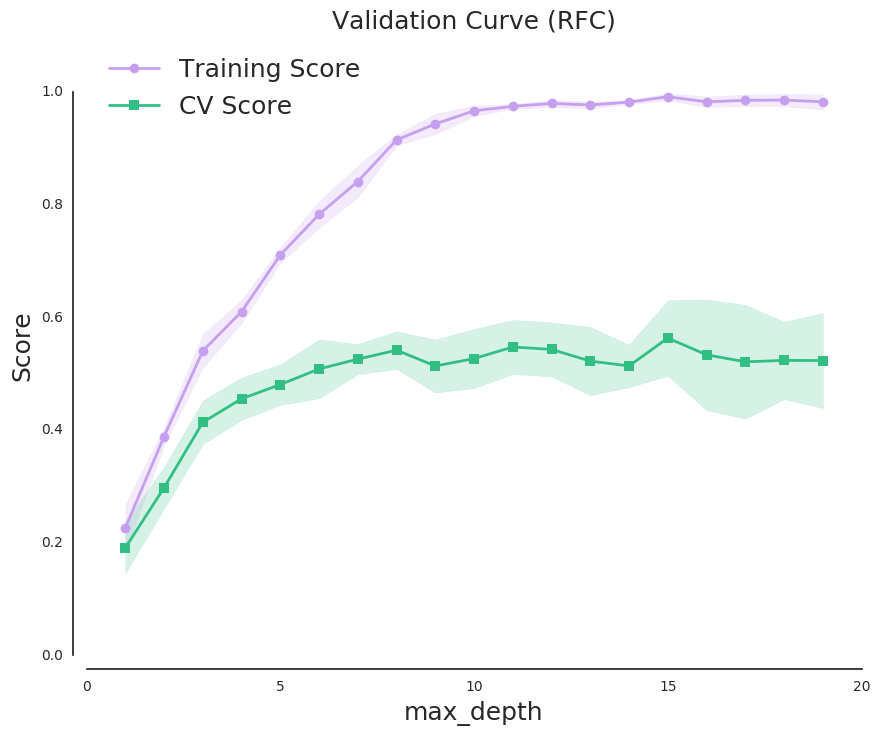

In [19]:
vc = plot_validation_curve(f_selected, c, check_random_state(0))

In [20]:
assert_is_instance(vc, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")

assert_equal(len(vc.lines), 2)

assert_is_not(len(vc.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(vc.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(vc.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")

# check lines
x_train, y_train = vc.lines[0].get_xydata().T
assert_array_almost_equal(x_train, np.arange(1,20))
assert_array_almost_equal(y_train, 
                          [ 0.22635556,  0.38835901,  0.54027221,  0.60997869,  0.71045737,
                            0.7825216 ,  0.84086324,  0.91471541,  0.94298356,  0.9663274 ,
                            0.9742014 ,  0.97935748,  0.97663546,  0.98165637,  0.99128017,
                            0.98225592,  0.98481485,  0.98539211,  0.98220311])

x_valid, y_valid = vc.lines[1].get_xydata().T
assert_almost_equal(x_valid, np.arange(1,20))
assert_array_almost_equal(y_valid, 
                        [ 0.19090551,  0.29747382,  0.41365137,  0.45535345,  0.48061187,
                          0.50834061,  0.52570965,  0.5416222 ,  0.51355724,  0.52669318,
                          0.54729495,  0.5429625 ,  0.52221434,  0.51364565,  0.56311908,
                          0.53339753,  0.52099856,  0.52343397,  0.5232402 ])

In [21]:
# check filled regions
p_train, p_valid = vc.collections

path_train = p_train.get_paths()[0].vertices
assert_equal(len(path_train), 41)
assert_array_almost_equal(path_train[:5], 
                          [[ 1.        ,  0.26823345],
                           [ 1.        ,  0.18447767],
                           [ 2.        ,  0.37238893],
                           [ 3.        ,  0.51056177],
                           [ 4.        ,  0.58950553]])
assert_array_almost_equal(path_train[-5:], 
                          [[ 4.        ,  0.63045185],
                           [ 3.        ,  0.56998265],
                           [ 2.        ,  0.40432908],
                           [ 1.        ,  0.26823345],
                           [ 1.        ,  0.26823345]])

path_valid = p_valid.get_paths()[0].vertices
assert_equal(len(path_valid), 41)
assert_array_almost_equal(path_valid[:5], 
                          [[ 1.        ,  0.23597253],
                           [ 1.        ,  0.14583849],
                           [ 2.        ,  0.26051277],
                           [ 3.        ,  0.37502207],
                           [ 4.        ,  0.41773231]])
assert_array_almost_equal(path_valid[-5:],
                         [[ 4.        ,  0.49297459],
                          [ 3.        ,  0.45228068],
                          [ 2.        ,  0.33443486],
                          [ 1.        ,  0.23597253],
                          [ 1.        ,  0.23597253]])